# Detector Beetle Field Trial - Data Analysis

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import fnmatch
import os
import gpxpy
import re

## Dataset

Dataset is a CSV text file, **detector_beetles1.csv** with the following fields:

* **beetle_id** Code engraved on beetle's elytrum
* **frequency** frequency (MHz) of radio transmitter glued to beetle's pronotum
* **rel_site** release site; Asan [13.473904, 144.708537]; Yigo [13.531333, 144.872750]
* **Notes** tracking notes
* **lat2** latitude of final observation (decimal degrees)
* **lon2** longitude of final observation (decimal degrees)
* **t2** timestamp of final observation (ChST)
* **extended_track_bearing** direction of travel from the final observation point (direct observation or radio direction finding)
* **end_point_located** 
* **in_tree** TRUE if end point is in a tree; determined visually or by radio direction finding
* **breeding_site** TRUE if otjer CRB present
* **flight_test_date** date on which beetle was flight tested and measured (ChST)
* **Sex** m or f
* **Length** lengthe of elytra (mm)
* **Width** width across elytra (mm)
* **Weight** mass (g)

In [2]:
df_endpoints = pd.read_csv('detector_beetles1.csv')
df_endpoints.sort(columns=['frequency'], inplace=True) # Sort by frequency
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
df_endpoints

,beetle_id,frequency,rel_site,Notes,lat2,lon2,t2,extended_track_bearing,end_point_located,in_tree,breeding_site,flight_test_date,Sex,Length,Width,Weight
0,2968,148.641,Asan,weak signal coming from swamp across from Asan Park; swamp,13.473933,144.708633,2015-08-11 09:18,180.00,False,NaN,NaN,2015-08-10,f,21.17,16.47,2.641
1,2977,148.671,Asan,Found at base of coco tree; just off beach,13.474933,144.708750,2015-08-11,NaN,True,False,NaN,2015-08-10,f,21.83,16.99,3.622
2,2991,148.693,Asan,Lost west over hill,13.472575,144.707141,2015-08-12 19:58:50,270.00,False,NaN,NaN,2015-08-11,m,25.86,20.63,5.774
3,2981,148.703,Asan,Lost west over hill; no track,NaN,NaN,NaN,270.00,False,NaN,NaN,2015-08-10,f,24.94,18.96,5.206
4,2971,148.732,Yigo,top of coconut tree adjust GPS,13.535104,144.873882,2015-08-12 11:00,NaN,True,True,NaN,2015-08-10,m,22.36,17.55,3.087
5,2929,148.752,NaN,lost; no track,NaN,NaN,2015-08-10,NaN,False,NaN,NaN,2015-08-05,f,25.41,20.29,4.220
6,2985,148.764,Asan,out of range; towards road,13.473374,144.708416,2015-08-10 21:01,180.00,False,NaN,NaN,2015-08-10,f,22.80,18.07,4.017
7,2963,148.782,Yigo,under trailer in the dirt; no track,13.529393,144.870394,2015-08-12 12:36,NaN,True,False,NaN,2015-08-10,m,20.33,16.28,3.179
8,2952,148.792,Yigo,beetle in breadfruit tree; 2952?; wooded,13.530583,144.872400,2015-08-10 09:30,NaN,True,True,True,2015-08-05,f,24.07,18.67,4.229
9,2978,148.820,Yigo,faint signal in woods; no track,13.529850,144.872300,2015-08-11 20:58,196.44,False,NaN,NaN,2015-08-10,m,25.22,20.15,5.213


## Map Beetle Tracks Using a Google Earth KML File

In [3]:
import pyproj
import math
import random

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
utm55n=pyproj.Proj("+init=EPSG:32655") # UTM coords, zone 55N, WGS84 datum

def extended_track(longitude, latitude, distance, bearing, bearing_jitter=0):
    """ Returns a track extended from a point for a given distance in a given direction.
    longitude, latitude: starting point in WGS84
    distance: distance to extend track in meters
    angle: angle in compass degrees (east = 90)
    angle_jitter: range of a uniform random number to be added or subracted from angle;
        for eaxmple, if angle=90 and angle_jitter=0.5, track will have an angle between 89.5 and 90.5
        
    Returns latitude and longitude of end point.
    """
    x, y = pyproj.transform(wgs84, utm55n, longitude, latitude)
    if bearing_jitter > 0:
        bearing = random.uniform(bearing-bearing_jitter, bearing+bearing_jitter)
    angle = math.radians(90.0 - bearing) # angle in radians
    x_final, y_final = (x + distance * math.cos(angle), y + distance * math.sin(angle))
    longitude_final, latitude_final = pyproj.transform(utm55n, wgs84, x_final, y_final) # Convert back to lnn/lat
    return longitude_final, latitude_final

#extended_track(144.70901, 13.47140, 500, 90, 0.5)
# (144.71362549035726, 13.471476650158763)

def get_bearing(lat1, lon1, lat2, lon2):
    """ Returns bearing between two geographical coordinates in decimal degrees
    """
    startLat = math.radians(lat1)
    startLong = math.radians(lon1)
    endLat = math.radians(lat2)
    endLong = math.radians(lon2)
    dLong = endLong - startLong
    dPhi = math.log(math.tan(endLat/2.0+math.pi/4.0)/math.tan(startLat/2.0+math.pi/4.0))
    if abs(dLong) > math.pi:
         if dLong > 0.0:
             dLong = -(2.0 * math.pi - dLong)
         else:
             dLong = (2.0 * math.pi + dLong)
    bearing = (math.degrees(math.atan2(dLong, dPhi)) + 360.0) % 360.0;
    return bearing

#get_bearing(43.682213, -70.450696, 43.682194, -70.450769)
# 250.20613449

In [4]:
df_traploc = pd.read_csv('trap_locations.csv')
df_traploc

,trap_id,trap_type,latitude,longitude
0,31,barrel,13.528873,144.874305
1,7,barrel,13.532839,144.873886
2,2,barrel,13.533570,144.871631
3,4,barrel,13.532723,144.871150
4,19,barrel,13.530503,144.871402
5,27,barrel,13.528861,144.870642
6,30,barrel,13.528853,144.873485
7,20,barrel,13.530413,144.872234
8,6,barrel,13.532695,144.872923
9,14,barrel,13.531208,144.871205


In [5]:
import simplekml

kml = simplekml.Kml()

# Set some styles

track_style = simplekml.Style()
track_style.linestyle.color = simplekml.Color.yellow
track_style.linestyle.width = 4

extended_track_style = simplekml.Style()
extended_track_style.linestyle.color = simplekml.Color.orange
extended_track_style.linestyle.width = 2

in_tree_point_style = simplekml.Style()
in_tree_point_style.iconstyle.color = simplekml.Color.red

on_ground_point_style = simplekml.Style()
on_ground_point_style.iconstyle.color = simplekml.Color.yellow

extended_track_point_style = simplekml.Style()
extended_track_point_style.iconstyle.color = simplekml.Color.orange

barrel_trap_style = simplekml.Style()
barrel_trap_style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/shaded_dot.png'
barrel_trap_style.iconstyle.color = simplekml.Color.cyan

defence_trap_style = simplekml.Style()
defence_trap_style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/shaded_dot.png'
defence_trap_style.iconstyle.color = simplekml.Color.orange

bucket_trap_style = simplekml.Style()
bucket_trap_style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/shaded_dot.png'
bucket_trap_style.iconstyle.color = simplekml.Color.red

# Tracks
# Extended tracks identified with a new point at the last observed waypoint

for i, row in df_endpoints.iterrows():
    if row.rel_site == 'Asan':
        coord1 = (144.708537, 13.473904)
    elif row.rel_site == 'Yigo':
        coord1 = (144.87275, 13.531333)
    else:
        continue

    if not pd.isnull(row.lon2) and not pd.isnull(row.lat2):
        coord2 = (row.lon2, row.lat2)
    else:
        coord2 = coord1
        
    ls = kml.newlinestring(name=str(row.beetle_id), coords=[coord1, coord2])
    ls.style = track_style
    
    # Points for beetles with extended tracks
    
    if not pd.isnull(row.extended_track_bearing):
        extended_coord = extended_track(coord2[0], coord2[1], 500, row.extended_track_bearing, 5.0)
        ls = kml.newlinestring(coords=[coord2, extended_coord])
        ls.style = extended_track_style
        pnt = kml.newpoint(name=str(row.beetle_id), coords=[coord2])
        pnt.style = extended_track_point_style
        
# Points for beetles tracked to end points       
# Color code icon red: in tree; yellow: on ground; NaN: ignore

for i, row in df_endpoints.iterrows():
    if row.end_point_located==True and not pd.isnull(row.in_tree):
        pnt = kml.newpoint(name=str(row.beetle_id), coords=[(row.lon2, row.lat2)]) 
        if row.in_tree == True:
            pnt.style = in_tree_point_style
        else:
            pnt.style = on_ground_point_style

# pheromone trap locations
df_traploc = pd.read_csv('trap_locations.csv')
for i, row in df_traploc.iterrows():
    pnt = kml.newpoint(name='', coords=[(row.longitude, row.latitude)])
    if row.trap_type == 'barrel':
        pnt.style = barrel_trap_style
    elif row.trap_type == 'DeFence':
        pnt.style = defence_trap_style
    elif row.trap_type == 'bucket':
        pnt.style = bucket_trap_style
    
# Netted greenwaste pile
kml.newlinestring(name='netted greenwaste pile', coords=[(144.8710433152515,13.53058572842185),
                                                         (144.8713265719704,13.53057402417171),
                                                         (144.8713256055892,13.53060568242766),
                                                         (144.8710387298571,13.53061628694512),
                                                         (144.8710433152515,13.53058572842185)])
kml.save('tracks.kml')

In [6]:
df_endpoints[df_endpoints['beetle_id'].isin([2974,2979,2965])]

,beetle_id,frequency,rel_site,Notes,lat2,lon2,t2,extended_track_bearing,end_point_located,in_tree,breeding_site,flight_test_date,Sex,Length,Width,Weight
15,2974,148.963,Yigo,"edge of dense woods, up high; wooded; no track",13.529167,144.872683,2015-08-11 19:31,181.72,False,NaN,NaN,2015-08-10,m,22.59,17.97,3.562
26,2979,164.232,Asan,Lost at indicated coordinates; went out of range,13.474440,144.708450,2015-08-10,351.03,False,NaN,NaN,2015-08-10,m,24.31,19.01,4.563
31,2965,164.357,Asan,towards tall grass only up high,13.472615,144.707277,2015-08-13 11:20,180.00,False,NaN,NaN,2015-08-10,f,22.13,17.13,2.989


## Generate LaTeX table

In [7]:
df_endpoints.to_latex('table.tex')

## Flight Displacement

In [8]:
# Calculates flight displacement in meters

for i, row in df_endpoints.iterrows():
    # Get release site in UTM
    if row.rel_site == 'Asan':
        x0, y0 = pyproj.transform(wgs84, utm55n, 144.708537, 13.473904)
    elif row.rel_site == 'Yigo':
        x0, y0 = pyproj.transform(wgs84, utm55n, 144.87275, 13.531333)
    else:
        continue
    
    if row.end_point_located and not pd.isnull(row.lon2):
        # Get end point in UTM and calculate displacement
        x1, y1 = pyproj.transform(wgs84, utm55n, row.lon2, row.lat2)
        displacement = int(((x1-x0)**2 + (y1-y0)**2)**0.5)
        df_endpoints.set_value(i, 'displacement', displacement)
    else:
        # For beetles not tracked to an end point,
        # estimate displacement as 500; changing this value should not alter 
        # the median displacement.
        df_endpoints.set_value(i, 'displacement', 500)
        
df_endpoints.tail()

,beetle_id,frequency,rel_site,Notes,lat2,lon2,t2,extended_track_bearing,end_point_located,in_tree,breeding_site,flight_test_date,Sex,Length,Width,Weight,displacement
29,2969,164.307,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,2015-08-10,f,24.19,19.10,4.811,NaN
30,2966,164.333,Yigo,In coco tree crown in private property; wooded,13.529730,144.871570,2015-08-12 11:43,NaN,True,True,NaN,2015-08-10,f,24.01,18.94,4.379,218
31,2965,164.357,Asan,towards tall grass only up high,13.472615,144.707277,2015-08-13 11:20,180,False,NaN,NaN,2015-08-10,f,22.13,17.13,2.989,500
32,2944,164.382,Asan,Asan; Did not fly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-05,m,22.93,17.73,2.881,500
33,2973,164.409,Yigo,in brush line around base of small papy; wooded,13.531440,144.871610,2015-08-11 20:32,NaN,True,False,NaN,2015-08-10,m,21.25,16.50,3.289,124


:0: FutureWarning: IPython widgets are experimental and may change in the future.


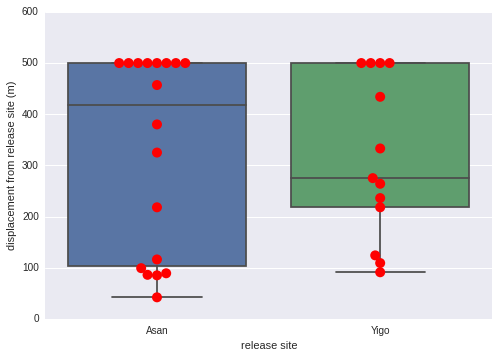

In [9]:
import seaborn as sns # needs version >= 0.7for swarmplot

ax = sns.boxplot(data=df_endpoints, x='rel_site', y='displacement')
ax = sns.swarmplot(data=df_endpoints, x='rel_site', y='displacement', color='red', size=10)
ax.yaxis.set_label_text('displacement from release site (m)')
ax.xaxis.set_label_text('release site')

fig = ax.get_figure()
fig.savefig("displacement.png")

In [10]:
# Use boostrap resampling to test for significant difference between medians

asan = df_endpoints.displacement[df_endpoints.rel_site=='Asan'].values
asan_median = np.median(asan)
asan_count = len(asan)

yigo = df_endpoints.displacement[df_endpoints.rel_site=='Yigo'].values
yigo_median = np.median(yigo)
yigo_count = len(yigo)

obs_diff = np.abs(asan_median - yigo_median)
pool = np.concatenate([asan, yigo])

actual_diff_exceeded = 0
for i in range(10000):
    asan = np.random.choice(pool, size=asan_count, replace=True)
    yigo = np.random.choice(pool, size=yigo_count, replace=True)
    diff = np.abs(np.median(asan)-np.median(yigo))
    if diff > obs_diff:
        actual_diff_exceeded += 1
        
s = """Median displacement at Asan = {} m
Median displacement at Yigo = {} m
Observed difference between medians = {} m
In 10,000 simulation trials, the observed difference was exceeded {} times.
Pooled median = {} m.
""".format(asan_median, yigo_median, obs_diff, actual_diff_exceeded, np.median(pool))
print s

Median displacement at Asan = 418.5 m
Median displacement at Yigo = 275.0 m
Observed difference between medians = 143.5 m
In 10,000 simulation trials, the observed difference was exceeded 3615 times.
Pooled median = 333.0 m.



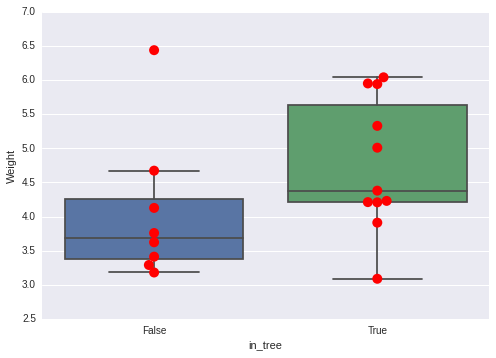

In [11]:
ax = sns.boxplot(data=df_endpoints, x='in_tree', y='Weight')
ax = sns.swarmplot(data=df_endpoints, x='in_tree', y='Weight', color='red', size=10)

## Mass Relationships

### Outcome vs mass for females

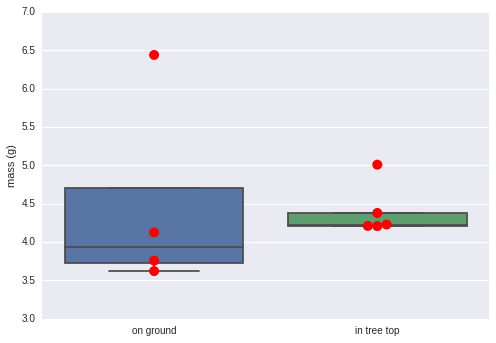

In [12]:
# Box plot for females
ax = sns.boxplot(data=df_endpoints[df_endpoints.Sex=='f'], x='in_tree', y='Weight')
ax = sns.swarmplot(data=df_endpoints[df_endpoints.Sex=='f'], x='in_tree', y='Weight', color='red', size=10)
ax.yaxis.set_label_text('mass (g)')
ax.xaxis.set_label_text('')
ax.xaxis.set_ticklabels(['on ground', 'in tree top'])

fig = ax.get_figure()

In [13]:
from scipy.stats import ttest_ind
df = df_endpoints
onground = df[(df.in_tree==False) & (df.Sex=='f')].Weight
intree = df[(df.in_tree==True) & (df.Sex=='f')].Weight
x = ttest_ind(onground.values, intree.values, equal_var=False)
s ='''
mean mass of female beetles on ground = {} g
mean mass of female beetles in tree tops = {} g
Welch's t = {}; p = {}
'''.format(onground.mean(), intree.mean(), x[0], x[1])
print(s)


mean mass of female beetles on ground = 4.48625 g
mean mass of female beetles in tree tops = 4.4072 g
Welch's t = 0.116721918047; p = 0.913775051869



### Outcome vs mass for males

In [14]:
# Add a new column, PEW, to the data frame and calcuate per cent emergent weight values
df_endpoints['PEW'] = 100*df_endpoints.Weight/(0.021*df_endpoints.Length*df_endpoints.Width-3.58)

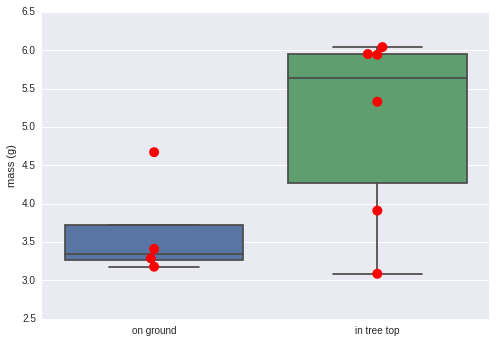

In [15]:
# Box plot for males
ax = sns.boxplot(data=df_endpoints[df_endpoints.Sex=='m'], x='in_tree', y='Weight')
ax = sns.swarmplot(data=df_endpoints[df_endpoints.Sex=='m'], x='in_tree', y='Weight', color='red', size=10)
ax.yaxis.set_label_text('mass (g)')
ax.xaxis.set_label_text('')
ax.xaxis.set_ticklabels(['on ground', 'in tree top'])

fig = ax.get_figure()

In [16]:
df = df_endpoints
onground = df[(df.in_tree==False) & (df.Sex=='m')].Weight
intree = df[(df.in_tree==True) & (df.Sex=='m')].Weight
x = ttest_ind(onground.values, intree.values, equal_var=False)
s ='''
mean mass of male beetles on ground = {} g
mean mass of male beetles in tree tops = {} g
Welch's t = {}; p = {}
'''.format(onground.mean(), intree.mean(), x[0], x[1])
print(s)


mean mass of male beetles on ground = 3.63775 g
mean mass of male beetles in tree tops = 5.04333333333 g
Welch's t = -2.27487468661; p = 0.0529436252401



### Outcome vs Percent Emergence Weight for Females

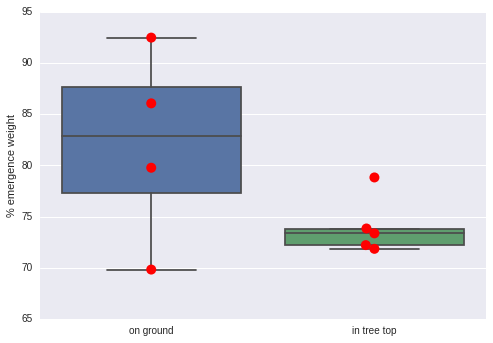

In [17]:
# Box plot for females
ax = sns.boxplot(data=df_endpoints[df_endpoints.Sex=='f'], x='in_tree', y='PEW')
ax = sns.swarmplot(data=df_endpoints[df_endpoints.Sex=='f'], x='in_tree', y='PEW', color='red', size=10)
ax.yaxis.set_label_text('% emergent weight')
ax.xaxis.set_label_text('')
ax.xaxis.set_ticklabels(['on ground', 'in tree top'])

fig = ax.get_figure()
fig.savefig('outcome_vs_pew_females.png')

In [18]:
# Stats for females
df = df_endpoints
onground = df[(df.in_tree==False) & (df.Sex=='f')].PEW
intree = df[(df.in_tree==True) & (df.Sex=='f')].PEW
x = ttest_ind(onground.values, intree.values, equal_var=False)
s ='''
mean PEW of female beetles on ground = {} g
mean PEW of female beetles in tree tops = {} g
Welch's t = {}; p = {}
'''.format(onground.mean(), intree.mean(), x[0], x[1])
print(s)


mean PEW of female beetles on ground = 82.0312239714 g
mean PEW of female beetles in tree tops = 74.008106905 g
Welch's t = 1.60764679017; p = 0.19536250506



### Outcome vs Percent Emergence Weight for Males

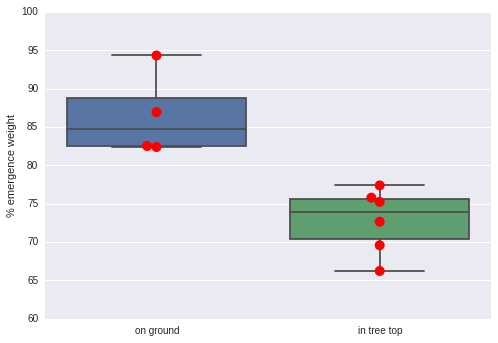

In [19]:
df_endpoints['PEW'] = 100*df_endpoints.Weight/(0.021*df_endpoints.Length*df_endpoints.Width-3.58)
ax = sns.boxplot(data=df_endpoints[df_endpoints.Sex=='m'], x=('in_tree'), y='PEW')
ax = sns.swarmplot(data=df_endpoints[df_endpoints.Sex=='m'], x='in_tree', y='PEW', color='red', size=10)
ax.yaxis.set_label_text('% emergent weight')
ax.xaxis.set_label_text('')
ax.xaxis.set_ticklabels(['on ground', 'in tree top'])

fig = ax.get_figure()
fig.savefig('outcome_vs_pew_males.png')

In [20]:
df = df_endpoints
onground = df[(df.in_tree==False) & (df.Sex=='m')].PEW
intree = df[(df.in_tree==True) & (df.Sex=='m')].PEW
x = ttest_ind(onground.values, intree.values, equal_var=False)
s ='''
mean PEW of male beetles on ground = {} g
mean PEW of male beetles in tree tops = {} g
Welch's t = {}; p = {}
'''.format(onground.mean(), intree.mean(), x[0], x[1])
print(s)


mean PEW of male beetles on ground = 86.5425526021 g
mean PEW of male beetles in tree tops = 72.8148390976 g
Welch's t = 4.17353946153; p = 0.00781040603136



## Create a tree graph showing outcomes for radio-tracked beetles

In [40]:
%%writefile outcomes.dot
# This dot file generates a png graph file using the command line:
# dot -Tpng -O outcomes.dot

digraph outcomes {
"Total beetles released\n n = 34" -> "Flew beyond detection\n range (>500m)\n n = 14";
"Total beetles released\n n = 34" -> "Did not fly\n n = 1";
"Total beetles released\n n = 34" -> "End point located\n n = 19";    
"End point located\n n = 19" -> "In tree\n n = 11"
"End point located\n n = 19" -> "On or below ground\n n = 8"
"In tree\n n = 11" -> "In crown of\n coconut palm\n n = 9"
"In tree\n n = 11" -> "In other tree species\n n = 2\n 1 confirmed breeding site"
"On or below ground\n n = 8" -> "Near base of\n coconut palm\n n = 3"   
"On or below ground\n n = 8" -> "Elsewhere on\n or below\n ground\n n = 3" 
"On or below ground\n n = 8" -> "Under barrel trap\n n = 2\n 1 confirmed breeding site"     
}

Writing outcomes.dot


In [41]:
# Generate outcomes.png containing a graph of outcomes for tracked beetles.
# graphview must be installed on your system for this to work
!dot -Tpng -O outcomes.dot

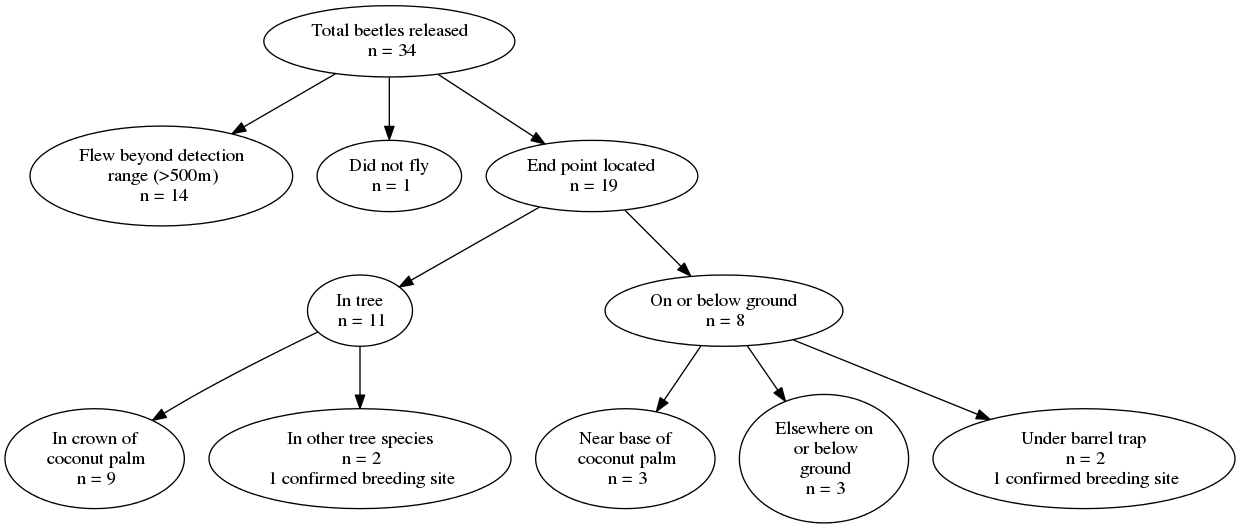

In [42]:
# Display outcomes.png
from IPython.display import Image
Image(filename='outcomes.png') 